# Pancreas endocrinogenesis E1415 - PMMs

### Imports and Settings

In [3]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [4]:
import numpy as np
import scanpy as sc
import cellrank as cr
import scvelo as scv
import jax
import jax.numpy as jnp
from tueplots import bundles
from tueplots import axes
import matplotlib.pyplot as plt

from neural_ot.utils import get_neural_dual_from_ckpt

In [5]:
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')  # for beautified visualization
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=200, transparent=True, fontsize=20, color_map='viridis')

cr.logging.print_versions()

plt.rcParams.update(**bundles.neurips2022(usetex=False, nrows=2), **axes.lines(base_width=0.5), **{"figure.dpi": 250})

cellrank==1.5.1+g16069e2 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.1 numba==0.53.1 scipy==1.9.0 pandas==1.3.5 pygpcca==1.0.3 scikit-learn==1.1.2 statsmodels==0.13.2 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


## Get trained model

In [6]:
# params
input_dim = 50
batch_size = 1024
first_quadratic_term = False
first_quadratic = True
ckpt_dir = f"ckpts/pancreas1415_pmm+gr"

In [7]:
# create and load neural dual
neural_dual = get_neural_dual_from_ckpt(
    ckpt_dir=ckpt_dir,
    first_quadratic_term=first_quadratic_term,
    first_quadratic=first_quadratic,
    input_dim=input_dim)

## Get Data

In [8]:
adata = sc.read("../neural_ot/data/pancreas/1415_growth_rate.h5ad")

In [9]:
# Prepare for Cellrank
adata.obs["clusters"] = adata.obs["celltype"]
adata = new_adata[:, :50].copy()
adata.layers["velocity"] = (neural_dual.transport(adata.obsm["X_pca"]) - adata.obsm["X_pca"])
adata.layers["velocity"] = np.asarray(adata.layers["velocity"].copy())
adata.layers["pca"] = adata.obsm["X_pca"].copy()

## Alternatively load precomputed adata

In [25]:
adata = sc.read("adata_results/pancreas1415_pmm+gr.h5ad")

## Cellrank

### Transition Probabilities

In [12]:
vk = cr.kernels.VelocityKernel(adata, xkey="pca")
vk.compute_transition_matrix()

  0%|          | 0/20519 [00:00<?, ?cell/s]

  0%|          | 0/20519 [00:00<?, ?cell/s]

VelocityKernel

### Macrostate and Terminalstate Calculation

In [13]:
g = cr.estimators.GPCCA(vk)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000087e+00 5.0462117934963384e-11 4.6280281617811676e-05 -1.0957271507339719e-03 -2.5424173135882521e-03 5.6760556577477761e-04 -1.1219902645358878e-02 -9.5081411578400426e-03 -3.2776578087560508e-02 1.2612442098489855e-03 1.5452324443558787e-02 5.1345301388224683e-03 -3.3665869679478107e-02 -2.9505979184971037e-02 -5.2591303719485283e-02 -2.6203788242257067e-02 4.3461697631003972e-02 -5.6002585084351016e-03 -1.6143932887571155e-02 -8.4908382451987872e-03 
0.0000000000000000e+00 9.9999999994048161e-01 -4.9964197802230295e-05 1.2025242240724183e-03 1.9936955134827621e-03 -1.3964795596821792e-03 1.3310901749265157e-02 1.4201602774268239e-02 2.7464859340082085e-02 3.1105117535582054e-04 -1.1749473249984339e-02 -5.2127225685382290e-03 2.5230935362683862e-02 7.6018729797643608e-03 3.6070378596760613e-02 4.8784838315399516e-02 -1.6738958022608233e-02 -2.0770623306068853e-02 2.8106552944088887e-02 6.6578853002839927e-03 
0.0000000000000

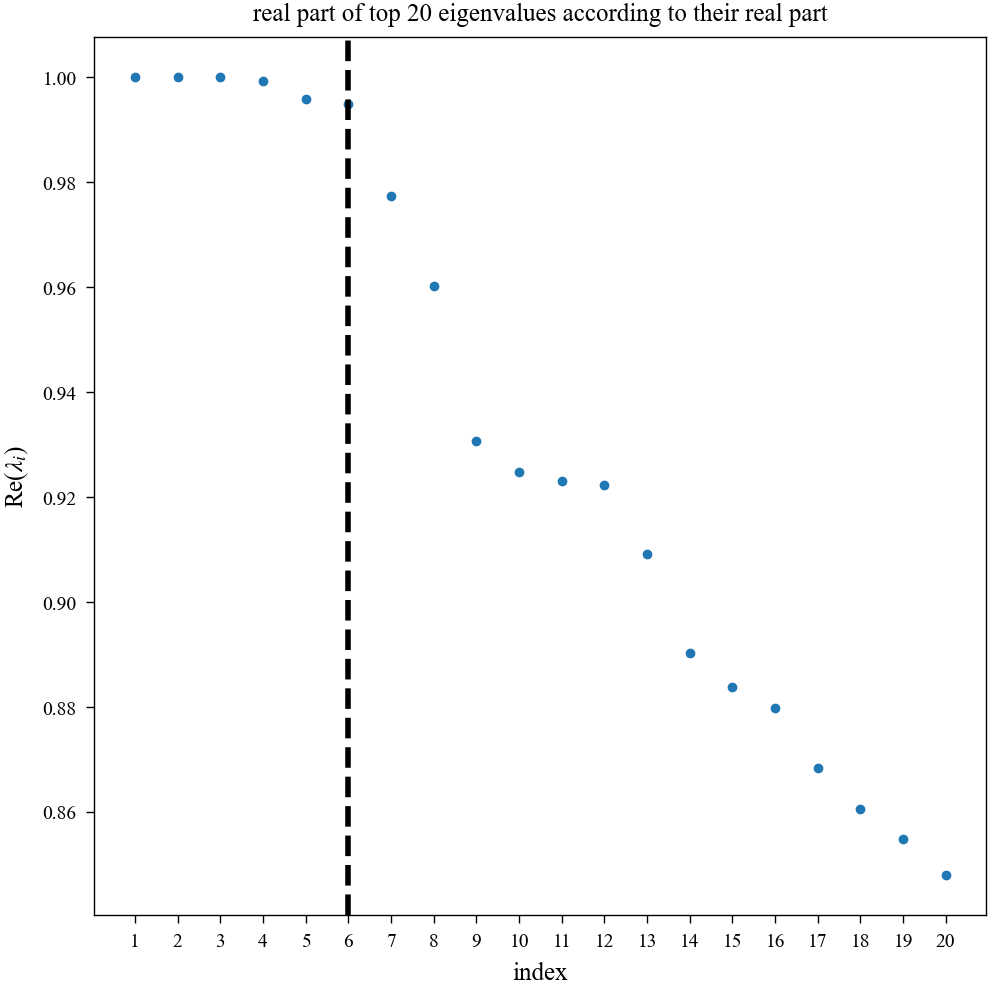

In [15]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

In [16]:
g.compute_macrostates(n_states=7, cluster_key="celltype")

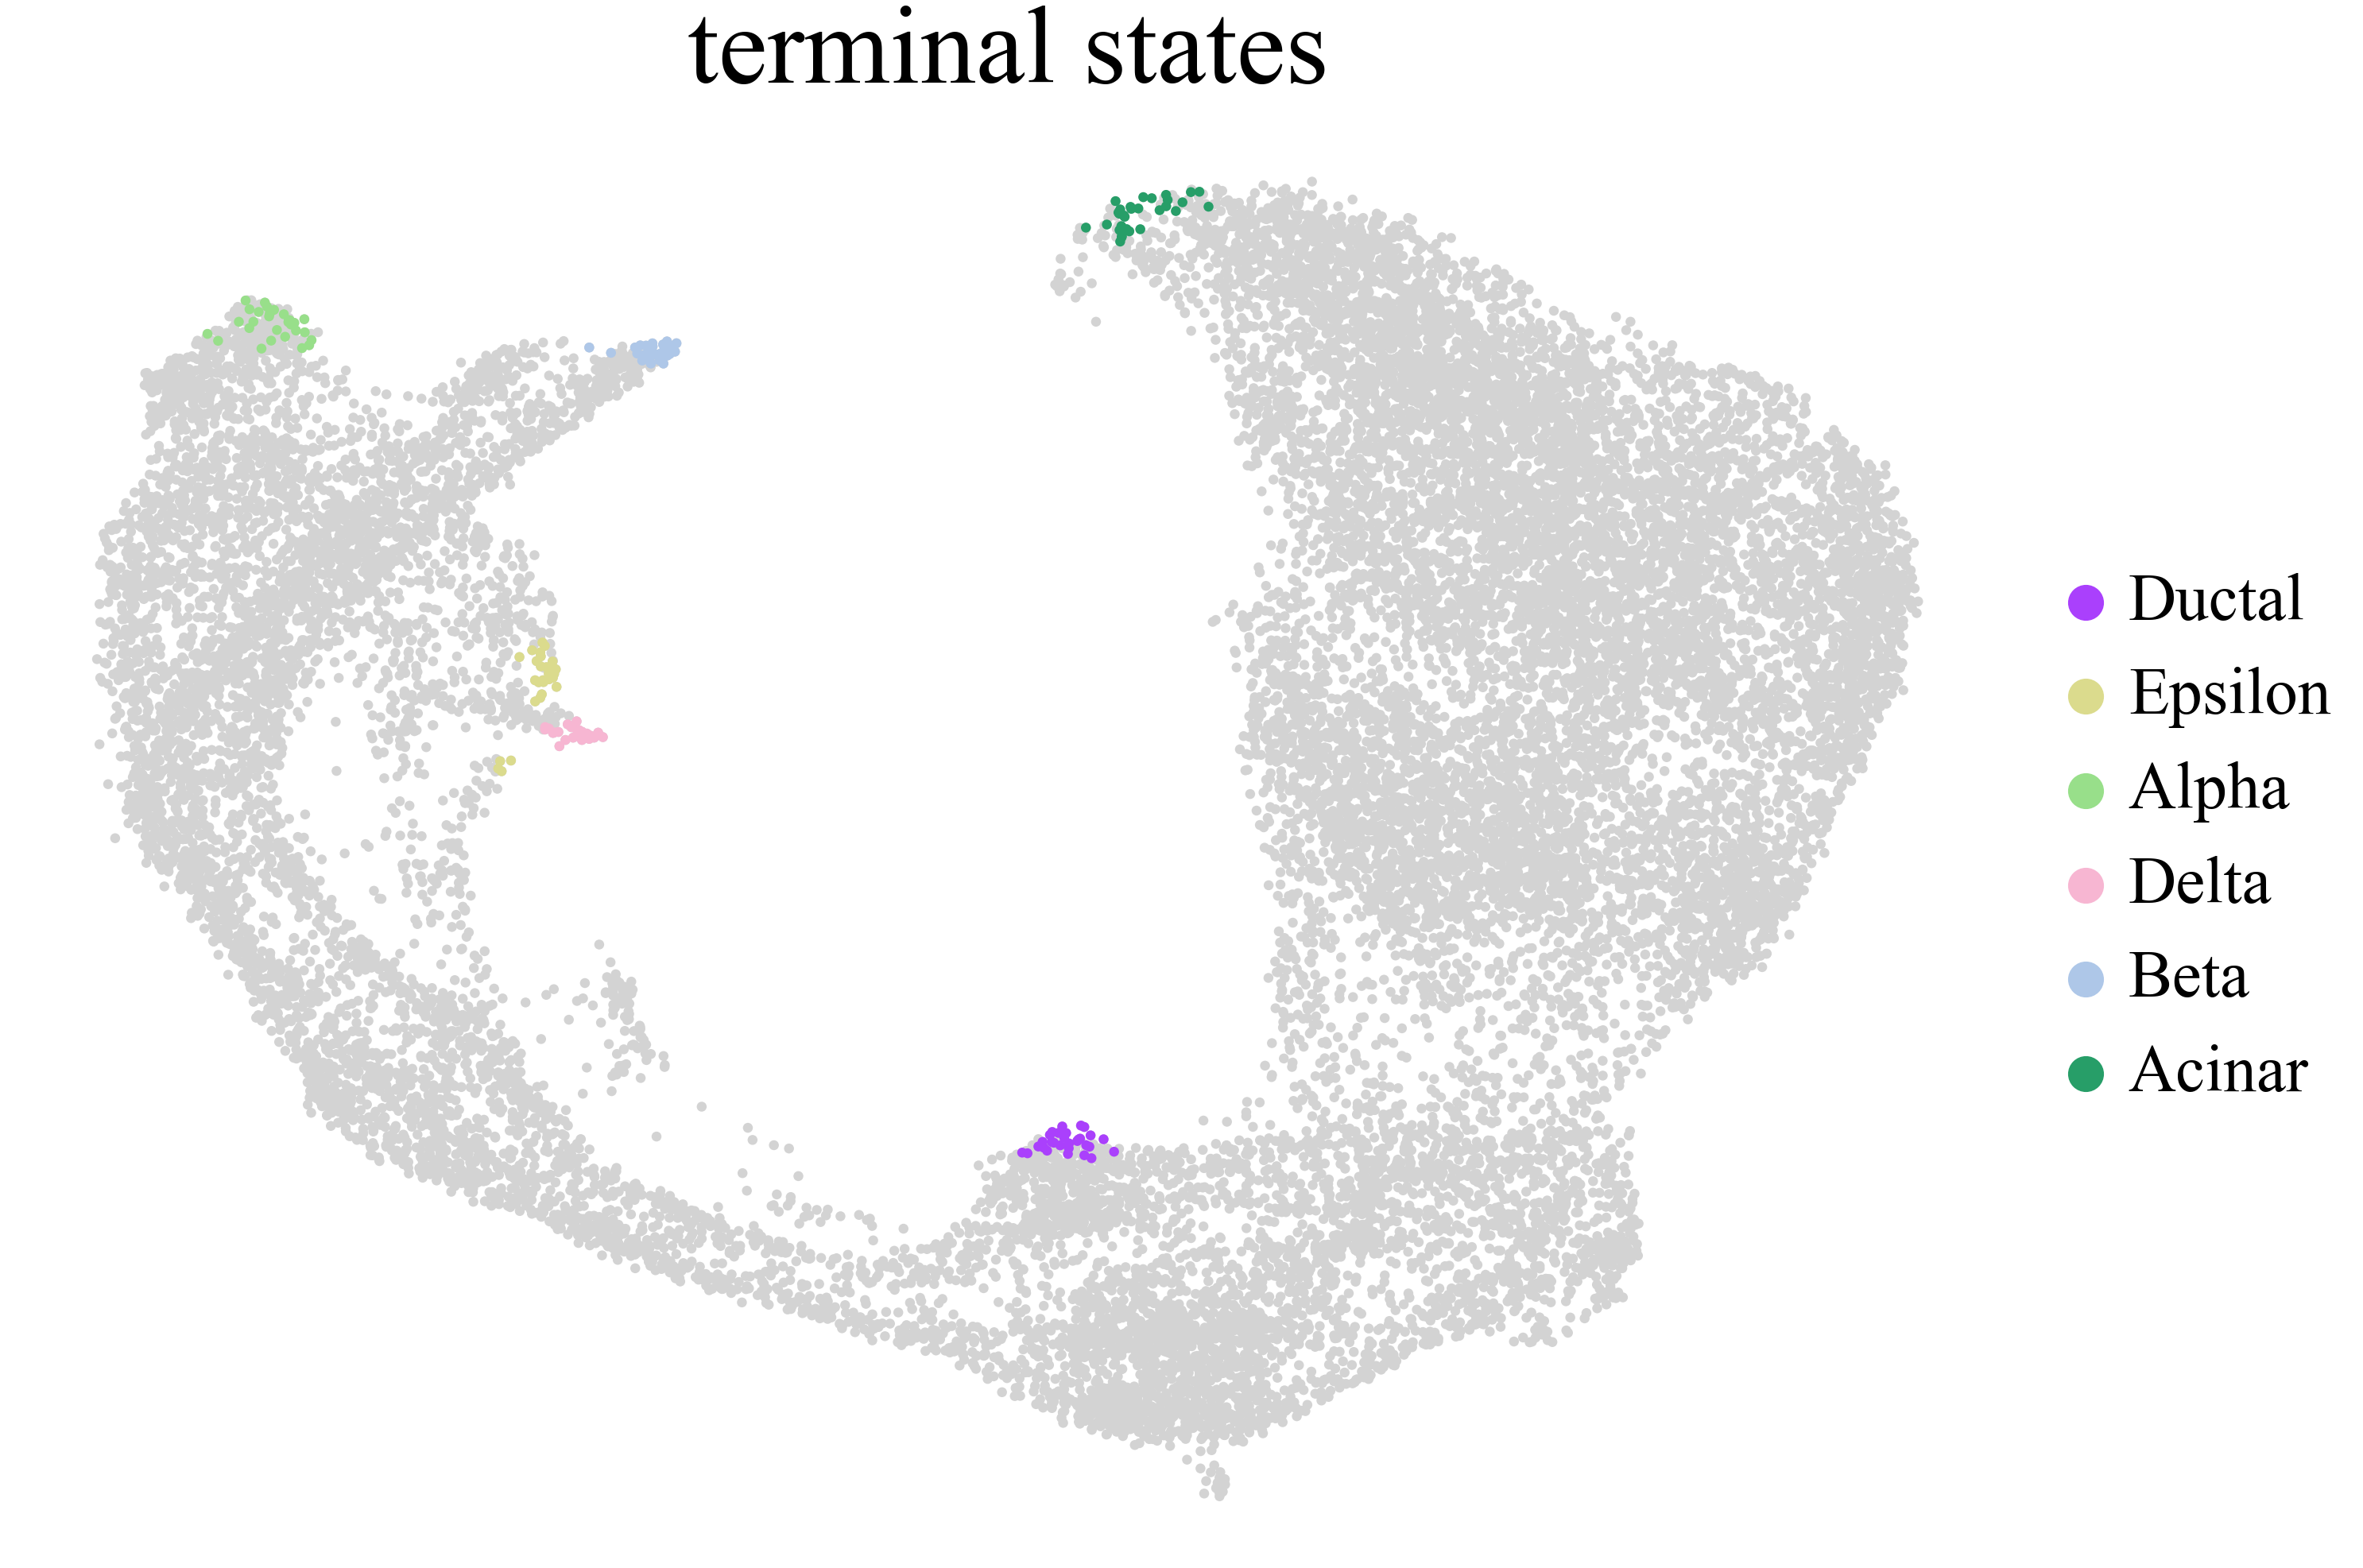

In [18]:
g.compute_terminal_states(method="top_n", n_states=6)
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_terminal_states(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

### Fate Probabilities

  0%|          | 0/6 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors

  0%|          | 0/1 [00:00<?, ?/s]

[0]PETSC ERROR: 

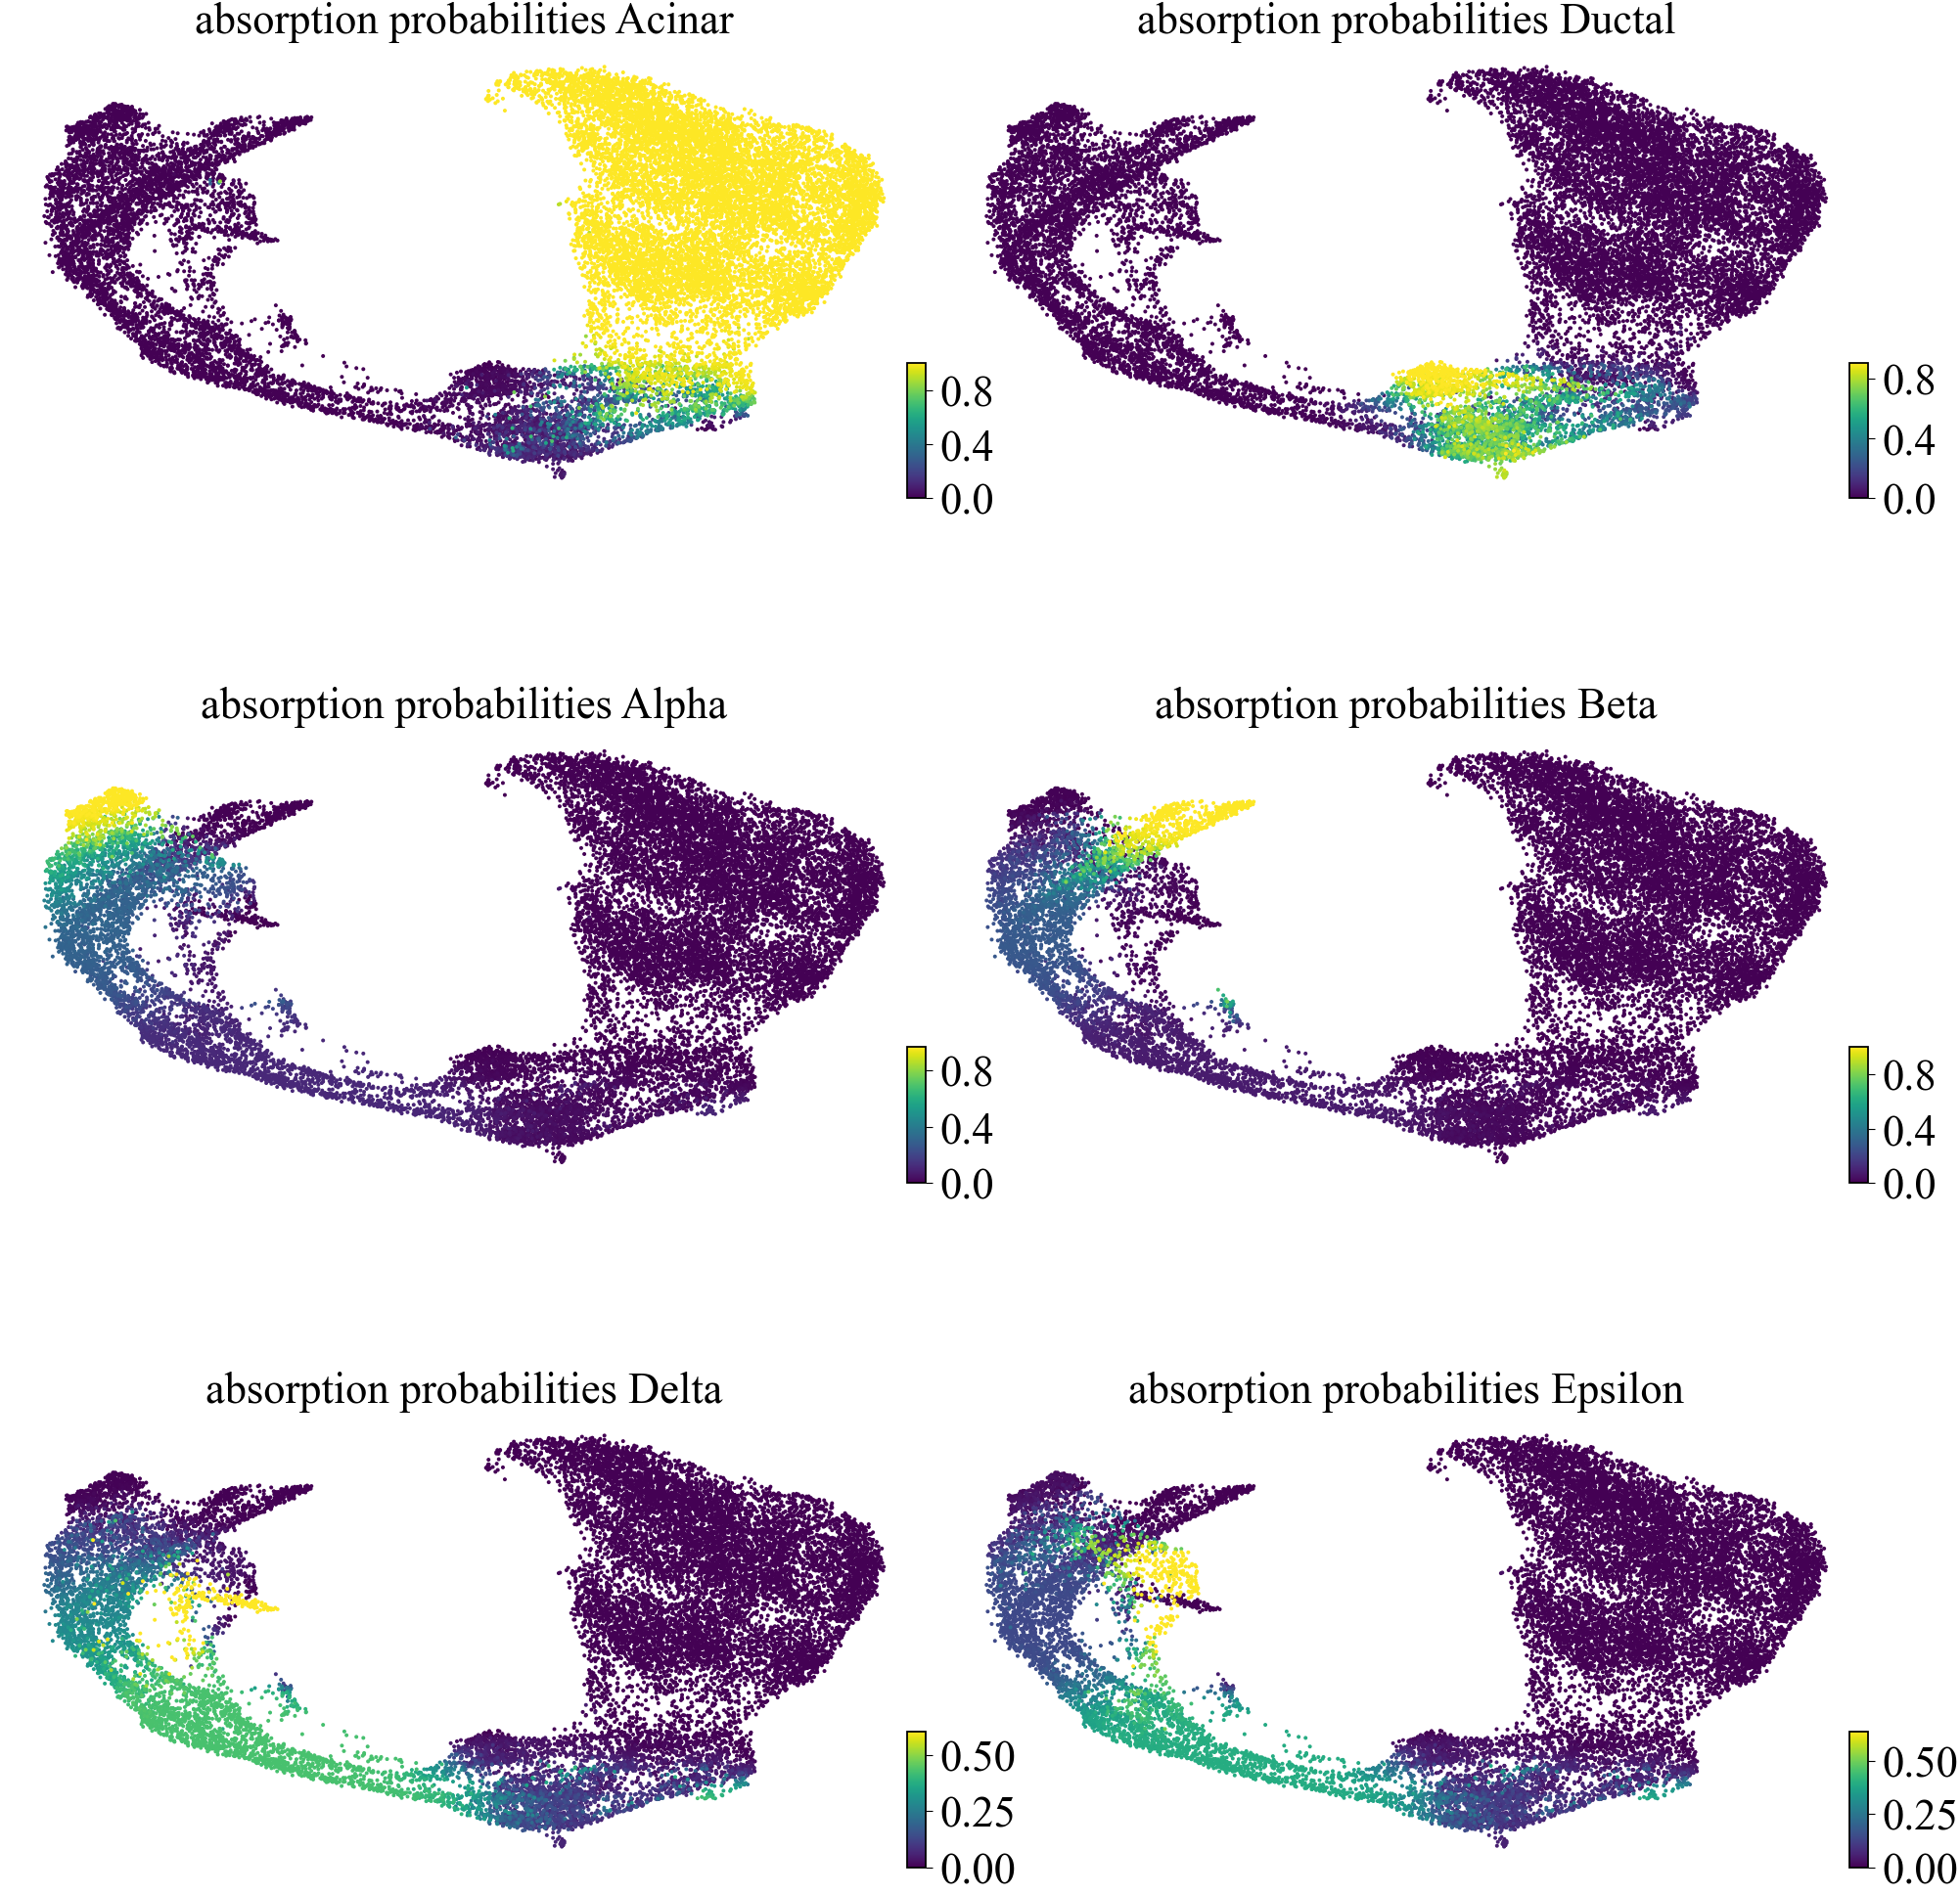

In [19]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar", "Ductal", "Alpha", "Alpha", "Beta", "Delta", "Epsilon"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

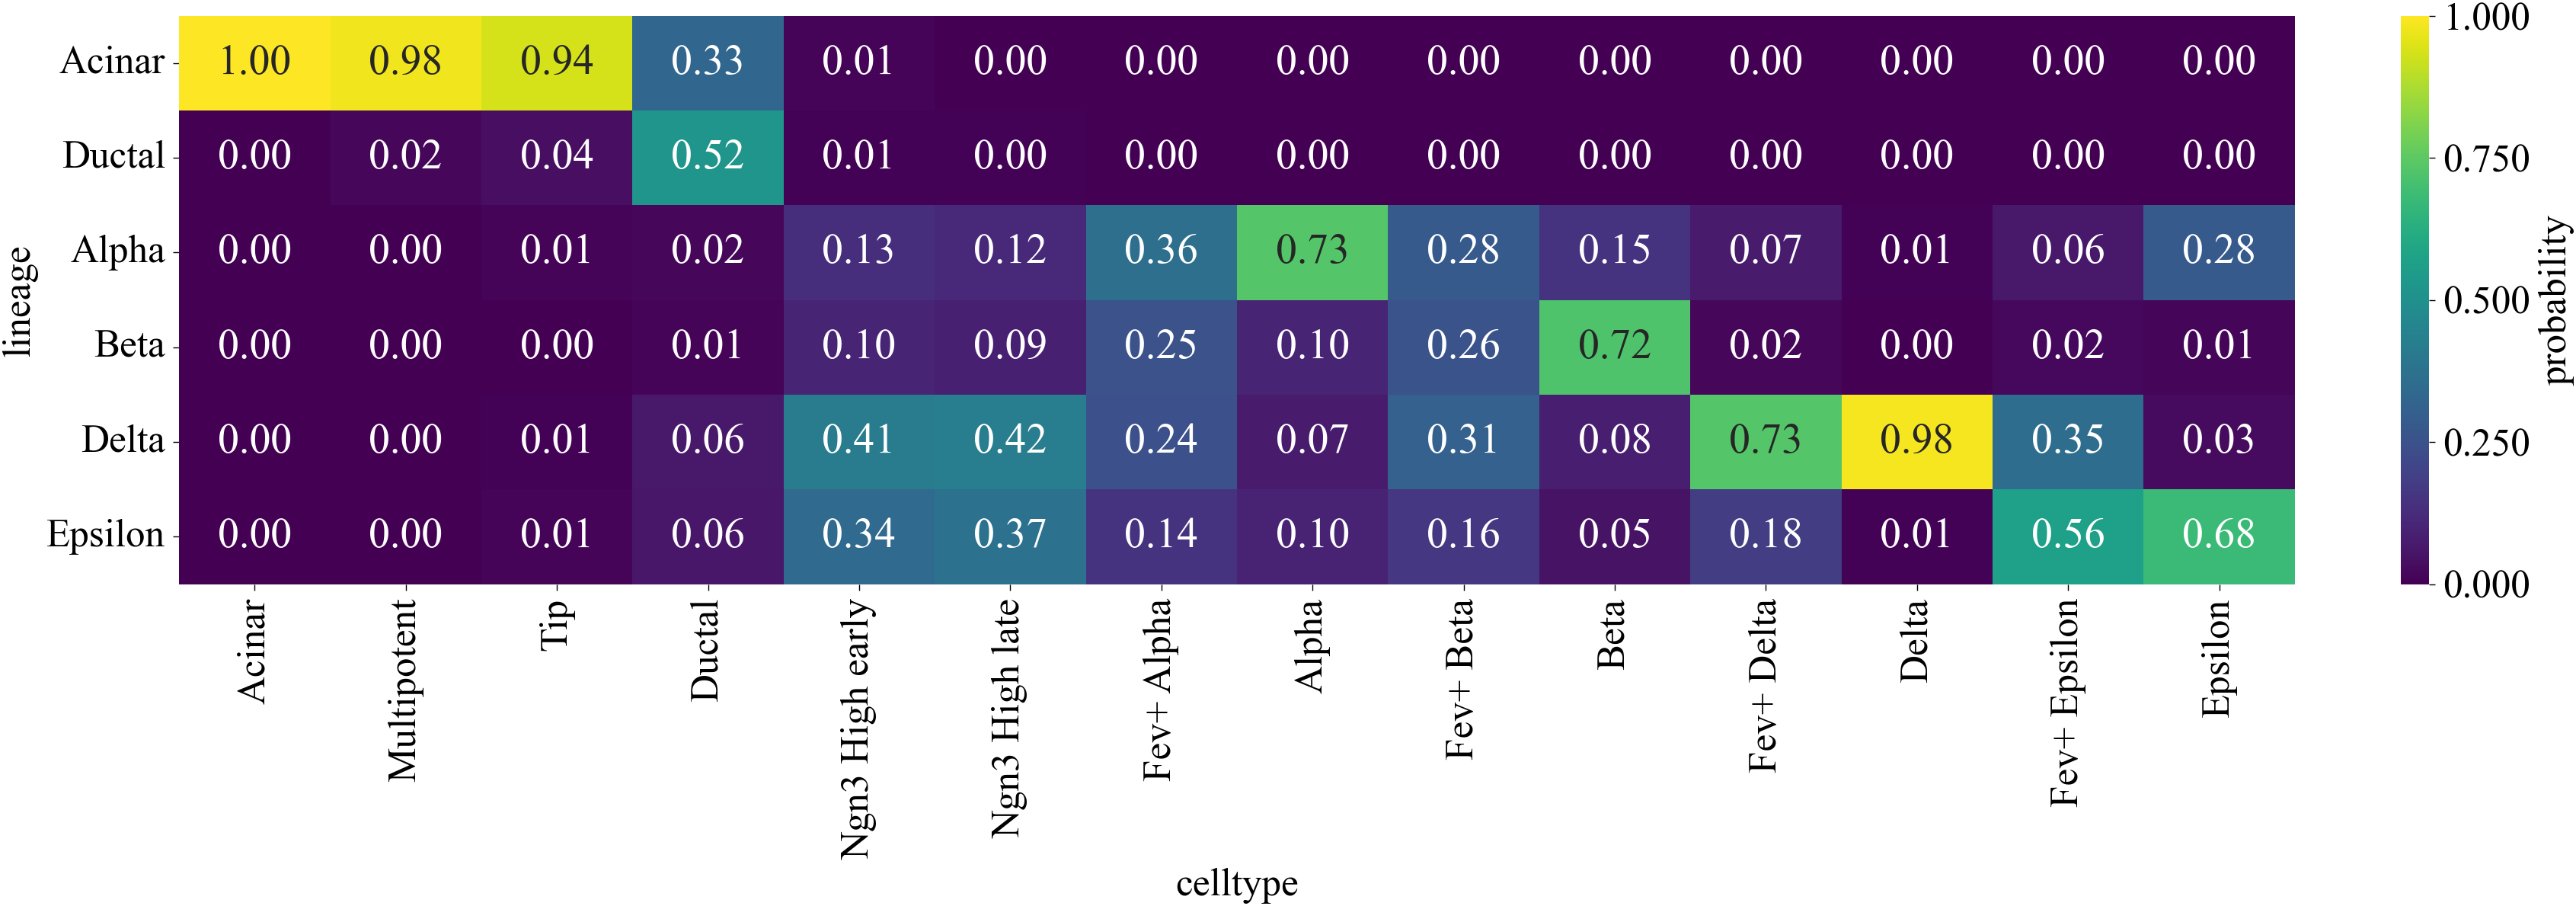

In [20]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')

cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
    #save="transprobs_pancreas1415_pmm+gr.png"
)

### Velocity Embedding Stream Plot

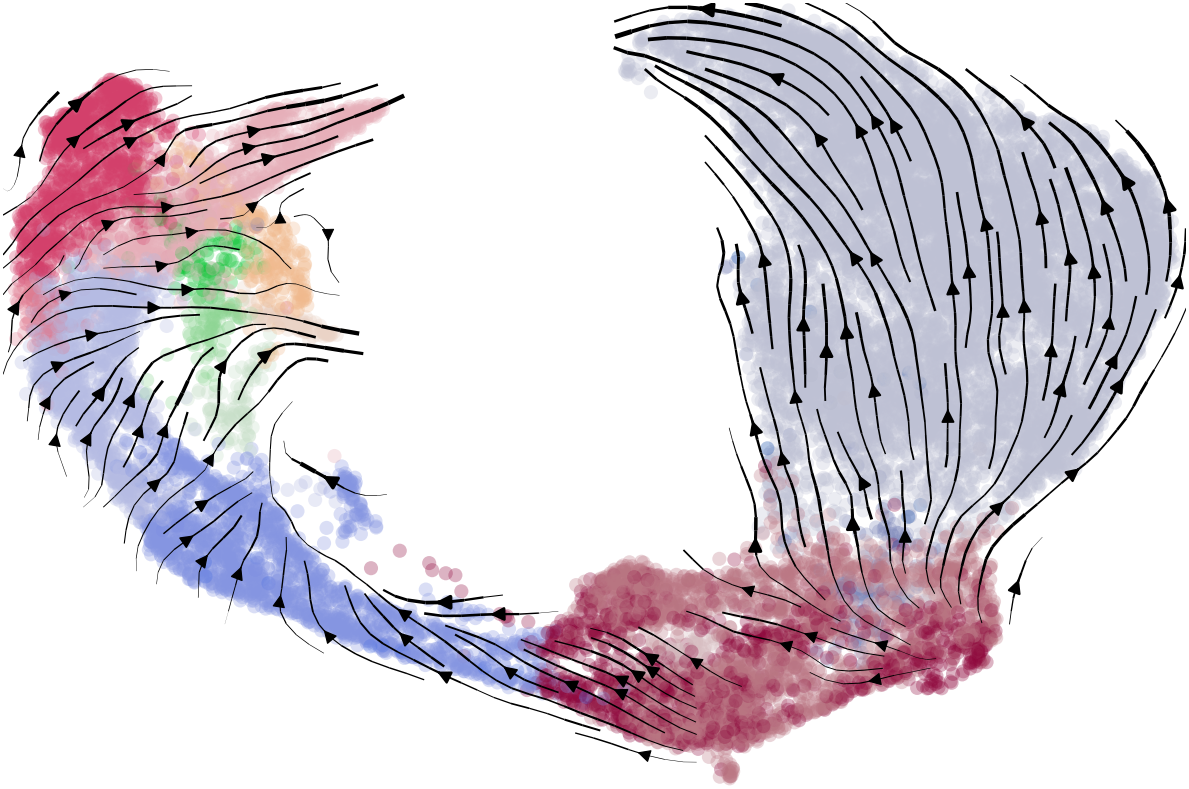

In [21]:
adata.uns["velocity_graph"] = vk.transition_matrix
scv.pl.velocity_embedding_stream(adata, basis="umap", title="", smooth=0.5, legend_loc='none')

In [22]:
adata.layers["Ms"] = adata.layers["pca"].copy()
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


In [23]:
scv.set_figure_params('scvelo', fontsize=20)
scv.settings.presenter_view = False

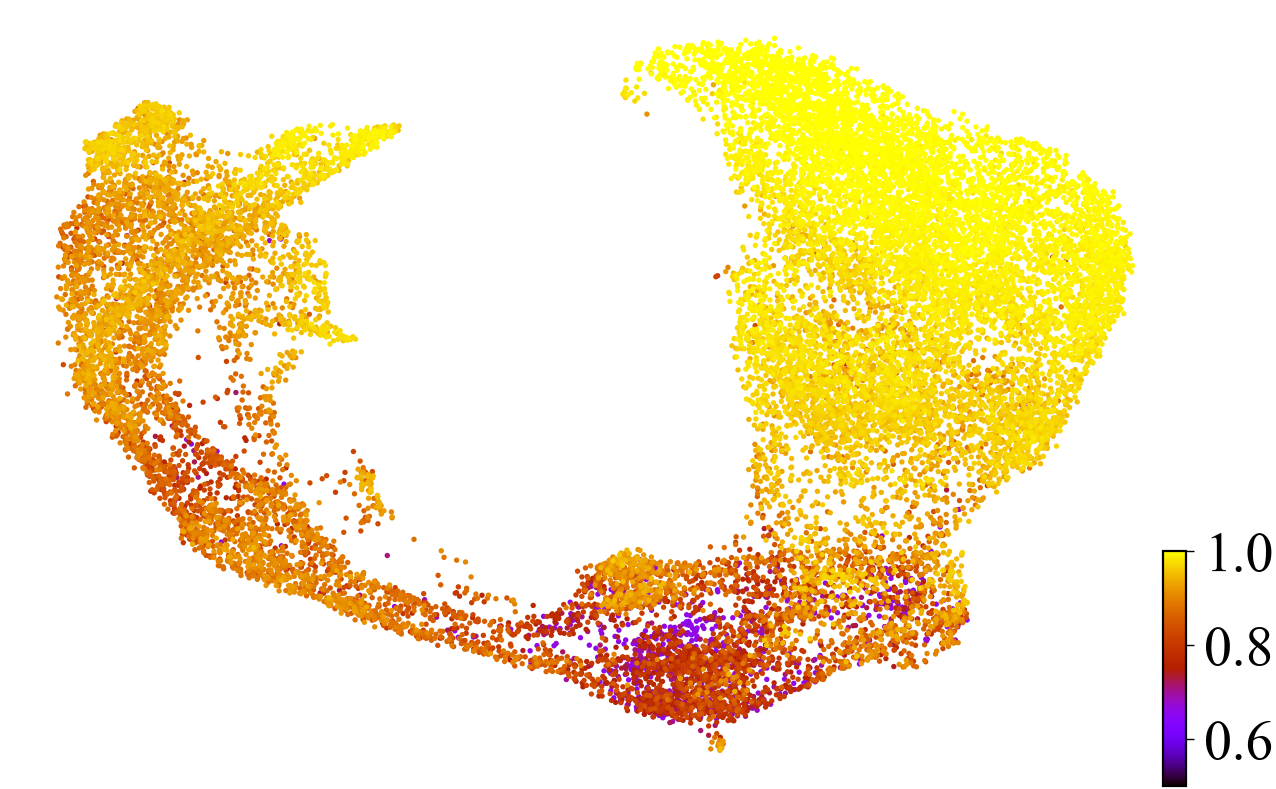

In [24]:
scv.pl.scatter(adata, color='velocity_confidence',
               perc=[2, 98],
               cmap='gnuplot',
               vmid=0.75,
               rescale_color=[0.5, 1.0],
               size=15,
               color_map="none",
               title="",
               #save="velconf_pancreas1415_pmm+gr.png"
              )